# Assigment 3: CAMSHIFT
## Paper
Read the paper "Bradski_etal_1998_camshift.pdf" in KVV (under "Resources/papers"). 

## Calculate histogram
* Implement a function that creates a color histogram. Pass either an image and ROI, or the image underlying the ROI. 
* For this purpose, a second (or third) parameter can be passed to specify the number of bins. 
* Load the image "images/racecar.png" and convert the image to the HSV color space. Plot the Hue channel. (**RESULT**)

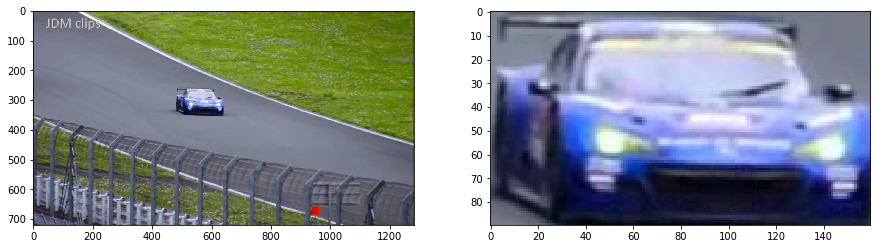

In [2]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')


IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20


image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(image)
ax2.imshow(imageCar)    

In [3]:
def createColorHistogram(img, binCount = 256, degrees = False, out = plt):
    hsv_img = color.rgb2hsv(img)
    hue_channel = hsv_img[...,0].flatten()
    if degrees == True:
        return plt.hist(hue_channel*360,binCount,range=(0.0,360.0),histtype='stepfilled', color='r', label='Hue')
    else: 
        return plt.hist(hue_channel ,binCount)

In [93]:
def createColorHistogramArray(img, binCount = 256):
    hsv_img = color.rgb2hsv(img)
    ticks = hsv_img.max()/binCount
    new_img = np.zeros(binCount)
    for i in np.arange (hsv_img.min(), hsv_img.max(), ticks): 
        new_img[int(i*binCount)]=(hsv_img == i).sum()
    return new_img

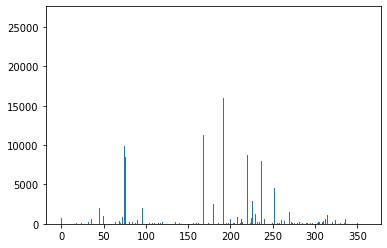

In [107]:
bins = 360
res = createColorHistogramArray(image, bins)
y_pos = np.arange(len(res))
size = np.zeros(bins)
# Create bars
plt.bar(y_pos, res)
plt.show()

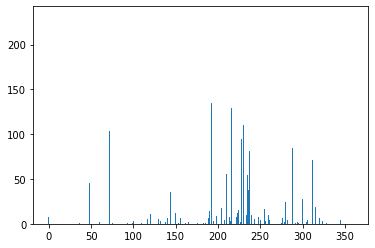

In [109]:
res2 = createColorHistogramArray(imageCar, bins)
size = np.zeros(bins)
# Create bars
plt.bar(y_pos, res2)
plt.show()

In [96]:
res.sum()

19156.0

* display the histogram for the Hue channel for the entire image and for the RIO (x,y) = (480, 260) to (640, 350). Vary the number of bins for testing purposes (**RESULT**).

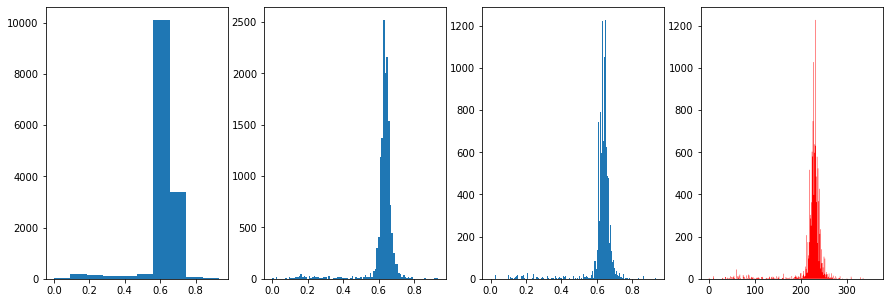

In [19]:
# Histograms for ROI image
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 4, 1)
histCar10 = createColorHistogram(imageCar, 10, ax1)
ax2 = plt.subplot(1, 4, 2)
histCar100 = createColorHistogram(imageCar, 100, ax2)
ax3 = plt.subplot(1, 4, 3)
histCar256 = createColorHistogram(imageCar, 256, ax3)
ax4 = plt.subplot(1, 4, 4)
histCar360 = createColorHistogram(imageCar, 360, True, ax4)

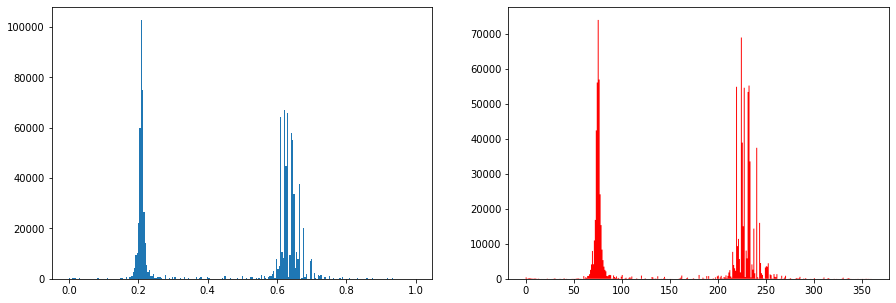

In [18]:
# Histograms for entire image
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
hist_whole_256 = createColorHistogram(image, 256, False, ax1)
ax2 = plt.subplot(1, 2, 2)
hist_whole_360 = createColorHistogram(image, 360, True, ax2)

## probability distribution
* implement the method outlined in the CAMSHIFT paper to create a probability distribution for a given object's hue histogram
* create the histogram of the car from the image "racecar.png" and apply the new function to the last frame of the video (images/racecar/151.jpg) (**RESULT**)


[0 0 0 ... 0 0 0]


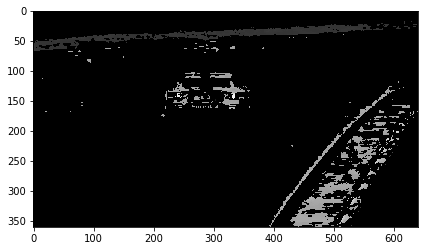

In [151]:
# Tip: in der Nacht sind alle Katzen grau ;)

def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    a_sum = objectHist.sum()
    H, W, C = image.shape
    new_img = np.zeros(H * W, np.uint8)
    prob = np.zeros(nbins)
    for i in range(0, nbins):
        prob[i] = (objectHist[i]/a_sum)*100
        if prob[i]>5:
            for j, (h, s, v) in enumerate(color.rgb2hsv(image).reshape(-1, C)):
                if v  > minValue and s > minSaturation: 
                    new_img[j] = h*255
                else: 
                    new_img[j] = 0
    print(new_img)
    return new_img.reshape(H, W)

lastFrame = io.imread('images/racecar/151.jpeg')
probDistr = createProbDistribution(lastFrame, res2, 360, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(probDistr, cmap ='gray')

[0 0 0 ... 0 0 0]


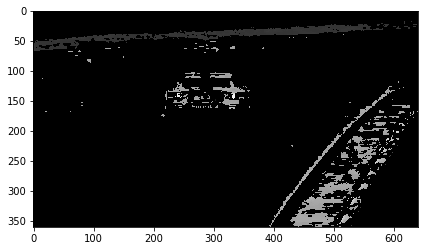

In [169]:
def createProbDistribution2(image, objectHist, nbins, minSaturation, minValue): 
    H, W, C = image.shape
    new_img = np.zeros(H * W, np.uint8)
    prob = np.zeros(nbins)
    a,b,c= objectHist
    a_sum = a.sum()
    for i in range(0, nbins):
        prob[i] = (a[i]/a_sum)*100
        if prob[i]>8:
            for j, (h, s, v) in enumerate(color.rgb2hsv(image).reshape(-1, C)):
                if v  > minValue and s > minSaturation: 
                    new_img[j] = h*255
                else: 
                    new_img[j] = 0
    print(new_img)
    return new_img.reshape(H, W)

histogramCar = createColorHistogram(imageCar, 360, ax1)
probDistr2 = createProbDistribution2(lastFrame, histogramCar, 360, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(probDistr2, cmap ='gray')

### show ROI in image


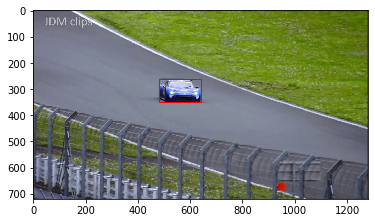

In [56]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )    
    out.imshow(image)

drawROI(image, 480, 260, 160, 90)

## Exercise 3.2 - Mean Shift
* Implement the Mean Shift method for a ROI as described in the lecture. Test the algorithm on the image sequences "images/racecar/*.jpg" or "images/taco/*.jpg". Select the appropriate tracking window (to reduce the file size I have reduced the images by a factor of 2, i.e. the ROI from above must be adjusted accordingly). 
* Draw the trajectory of the objects as returned by Mean Shift. (**RESULT**)

In [ ]:
How to Calculate the Mean Shift Algorithm
1. Choose a search window size.
2. Choose the initial location of the search window.
3. Compute the mean location in the search window.
4. Center the search window at the mean location
computed in Step 3.
5. Repeat Steps 3 and 4 until convergence (or until the
mean location moves less than a preset threshold).

where I(x,y) is the pixel (probability) value at position
(x,y) in the image, and x and y range over the search
window.

In [ ]:
x, y = mgrid[:image.shape[0],:image.shape[1]]
m00 = sum(image)
m01= sum(x*image)
m10 = sum(y*image)
mean_x = sum(x*image)/sum(image)
mean_y = sum(y*image)/sum(image)

##  Exercise 3.3 - CAMSHIFT
* extend your algorithm by adjusting the size of the ROI and finding the object's orientation
* execute the algorithm again on one of the image sequences and draw an ellipse on the image, which represents the found parameters (**RESULT**)

In [ ]:
1. First, set the calculation region of the probability
distribution to the whole image.
2. Choose the initial location of the 2D mean shift
search window.
3. Calculate the color probability distribution in the 2D
region centered at the search window location in an
area slightly larger than the mean shift window size.
4. Mean shift to convergence or for a set number of
iterations. Store the zeroth moment (area or size) and
mean location.
5. For the next video frame, center the search window at
the mean location stored in Step 4 and set the window